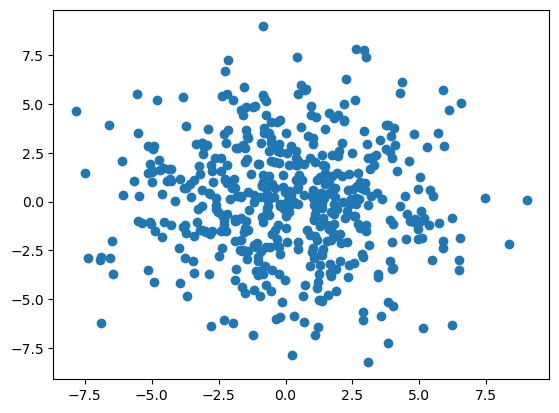

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import uuid
from sortedcontainers import SortedList
import numpy as np

points = np.random.normal(0,3,size=(500, 2))
# points = np.random.uniform(low=[-5,-5],high=[5,5],size=(1000,2))
plt.scatter(points[:, 0], points[:, 1])
data = [(str(uuid.uuid4()), p) for p in points]

In [3]:
class KMeans:
    
    def __init__(self, k=3, tol=1e-4, max_iter=300):
        self.k = k
        self.tol = tol
        self.max_iter = max_iter
        
    def fit(self, data):
        self.centroids = {}
        
        np.random.shuffle(data)
        for i in range(self.k):
            self.centroids[i] = data[i]
        
        for i in range(self.max_iter):
            self.classifications = {}
            for j in range(self.k):
                self.classifications[j] = []
                
            for d in data:
                distances = [np.linalg.norm(d-self.centroids[c]) for c in self.centroids]
                classification = np.argmin(distances)
                self.classifications[classification].append(d)
            
            prev_centroids = dict(self.centroids)
            for classification in self.classifications:
                self.centroids[classification] = np.average(self.classifications[classification], axis=0)
            ok = True
            for c in self.centroids:
                prev = prev_centroids[c]
                cur = self.centroids[c]
                if np.sum((prev-cur) / prev * 100.0) > self.tol:
                    ok = False
                    break
            if ok:
                break
                
a = KMeans(k=3)

In [4]:
%%timeit -r 5 -n 20
# %%prun
a.fit(points)

30.9 ms ± 4.27 ms per loop (mean ± std. dev. of 5 runs, 20 loops each)


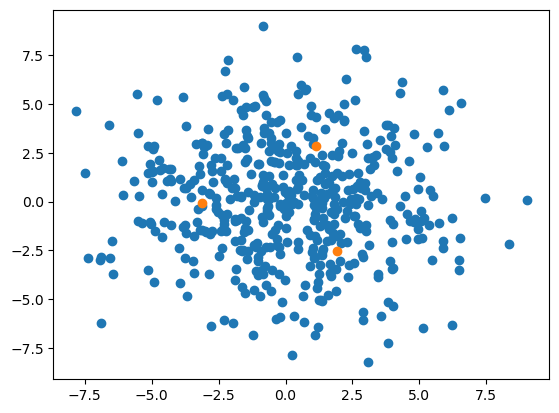

In [5]:
centroids = np.array([val for val in a.centroids.values()])

plt.scatter(points[:, 0], points[:, 1])
plt.scatter(centroids[:, 0], centroids[:, 1])

In [87]:
# data should look like this
# {uid of the point: corrdinate in d-dimension}

class TKM:
    
    def __init__(self, k=3, tol=1e-4, max_iter=300):
        self.k = k
        self.tol = tol
        self.max_iter = max_iter
    
    def UB_Y(p, m_p, theta_p, M, delta):
        d1 = np.linalg.norm(p-m_p)
        cur_min = None
        for m in M:
            if np.array_equal(m, m_p):
                continue
            if cur_min==None:
                cur_min = np.linalg.norm(p, m)
            else:
                cur_min = min(cur_min, np.linalg.norm(p, m))
        return np.square(d1+delta+theta_p) - np.square(max(0, cur_min-delta-theta_p))

# P is a list of tuple (uuid, vector)
# m is a map from uuid of the point to the index of the point's corresponding center 
# (e.g. m[p_1]=2 means M[2] is m[p_1]'s clustering center)
# classifications is a map from the index of the center to the list of points belonging to this center
    def compute_threshold(P, M, m, classifications, delta_1, delta_2):
        delta = delta_1 + delta_2
        Theta = {}
        P_move = []
        for p in P:
            Theta[p[0]] = delta_1
        for p in P:
            if UB_Y(p[1], M[m[p[0]]], Theta[p[0]], M, delta) < 0:
                P_move.append(p)
        ok = False
        while not ok:
            ok = True
            d_p = {}
            d_p_prime = {}
            for p in P_move:
                d_p[p[0]] = np.linalg.norm(p[1]-M[m[p[0]]])
                d_p_prime[p[0]] = None
                for i in range(len(M)):
                    if i == m[p[0]]:
                        continue
                    if d_p_prime[p[0]] == None:
                        d_p_prime[p[0]] = np.linalg.norm(p[1]-M[i])
                    else:
                        d_p_prime[p[0]] = min(np.linalg.norm(p[1]-M[i]), d_p_prime[p[0]])
            for p in P_move:
                # Decrease theta_p so that it satisfies theta_p <= minm∈M\{mp}dist(p,m)−Δ
                Theta[p[0]] = d_p_prime[p[0]] - delta
                # Let theta_p_aster be results of evaluating Equation 4.11
                sum_1 = np.sum([np.sqrt(d_p[q[0]]+d_p_prime[q[0]]) for q in P_move])
                sum_2 = np.sum([np.square(d_p[q[0]]+delta)-np.square(d_p_prime[q[0]]-delta) for q in P_move])
                min_cardi = np.min([len(x) for x in classifications.values()])
                theta_p_aster = np.sqrt(d_p[p[0]]-d_p_prime[p[0]])/(2*(d_p[p[0]]+d_p_prime[p[0]])*sum_1)*(min_cardi*np.square(delta_2)-sum_2)
                if theta_p_aster < Theta[p[0]]:
                    Theta[p[0]] = theta_p_aster
            for p in P_move:
                if UB_Y(p[1], M[m[p[0]]], Theta[p[0]], M, delta) <= 0:
                    P_move.remove(p)
                    ok = False
            return Theta
    
    def fit(self, data,prev_centre=None):
        self.d = {}
        self.d_prime = {}
        self.centers = {}
        self.classifications = {}
        self.m = {}
        self.SUM = {}
        self.sigma = 0
        
        # Initialize centroids (or centers)
#         np.random.shuffle(data)
        if (prev_centre==None):
            for i in range(self.k):
                self.centers[i] = data[i][1]
                self.m[data[i][0]] = i
                self.classifications[i] = []
        else:
            for i in range(self.k):
                self.centers[i]=prev_centre[i]
                self.classifications[i] = []
            
        for p in data:
            distances = [np.linalg.norm(p[1]-self.centers[c]) for c in self.centers]
            classification = np.argmin(distances)
            self.classifications[classification].append(p)
            self.m[p[0]] = classification
            
        # Initialize d and d_prime
        for p in data:
            self.d[p[0]] = np.linalg.norm(p[1]-self.centers[self.m[p[0]]])
            cur_min = None
            for c in self.centers:
                if c==self.m[p[0]]:
                    continue
                if cur_min==None:
                    cur_min = np.linalg.norm(p[1]-self.centers[c])
                else:
                    cur_min = min(cur_min, np.linalg.norm(p[1]-self.centers[c]))
            self.d_prime[p[0]] = cur_min
            
        # Initialize P_active
        ## H is a binary search tree of tuple (d-d', uid)
        self.H = SortedList([(self.d_prime[p[0]]-self.d[p[0]], p[1], p[0]) for p in data], key=lambda x:x[0])
        self.P_active = list(self.H.islice(0, self.H.bisect_left((0, None, None))))
        
        # Initialize SUM
        for c in self.centers:
            self.SUM[c] = np.vstack([k[1] for k in self.classifications[c]]).sum(axis=0)   
            
        # Main loop
        ok = False
        for i in range(self.max_iter):
            ok = True
            for p in self.P_active:
                distances = [np.linalg.norm(p[1]-self.centers[c]) for c in self.centers]
                nearest = np.argmin(distances)
                if nearest != self.m[p[2]]:
                    self.SUM[self.m[p[2]]] = np.subtract(self.SUM[self.m[p[2]]], p[1])
                    self.SUM[nearest] = np.add(self.SUM[nearest], p[1])
                    self.m[p[2]] = nearest
            for c in self.centers:
                m_g = self.SUM[c]/len(self.classifications[c])
                self.sigma = max(self.sigma, np.linalg.norm(self.centers[c]-m_g))
                if np.sum((self.centers[c]-m_g)/self.centers[c] * 100.0) > self.tol:
                    ok = False
                self.centers[c] = m_g
            if ok:      #Breaks when the new centres and the old centres dont have much difference
                break
            self.P_active = list(self.H.islice(0, self.H.bisect_left((self.sigma, None, None))))

model = TKM(k=3)

In [7]:
%%timeit -r 5 -n 20
model.fit(data)

12.1 ms ± 1.07 ms per loop (mean ± std. dev. of 5 runs, 20 loops each)


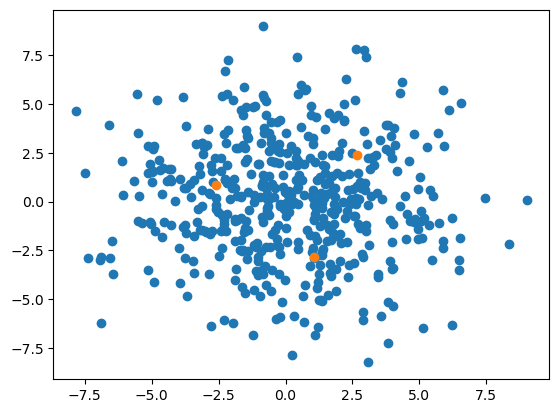

In [8]:
prev_centre=model.centers
centers = np.array([val for val in model.centers.values()])
plt.scatter(points[:, 0], points[:, 1])
plt.scatter(centers[:, 0], centers[:, 1])

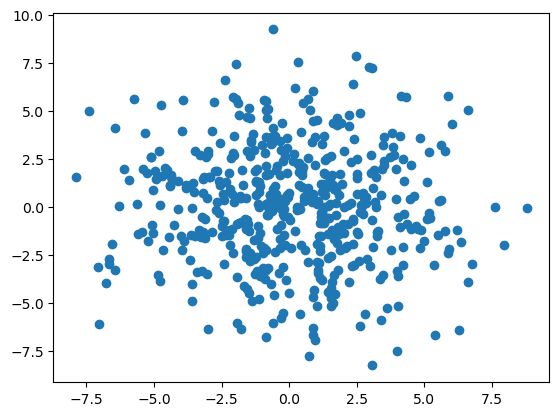

In [9]:
new_points = np.random.normal(points,0.2)
plt.scatter(new_points[:, 0], new_points[:, 1])
new_data = [(str(uuid.uuid4()), p) for p in new_points]

In [10]:
%%timeit -r 5 -n 20
a.fit(new_points)

26.7 ms ± 1.51 ms per loop (mean ± std. dev. of 5 runs, 20 loops each)


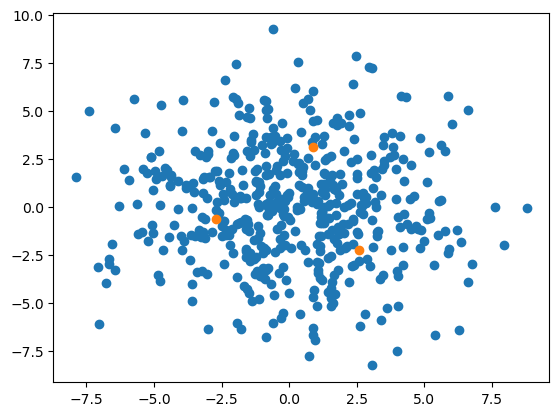

In [11]:
centroids = np.array([val for val in a.centroids.values()])

plt.scatter(new_points[:, 0], new_points[:, 1])
plt.scatter(centroids[:, 0], centroids[:, 1])

In [13]:
%%timeit -r 5 -n 20
model.fit(new_data,prev_centre)

6.75 ms ± 915 µs per loop (mean ± std. dev. of 5 runs, 20 loops each)


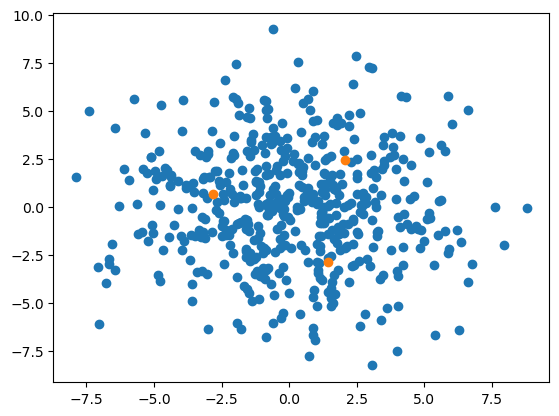

In [14]:
model.centers
centers = np.array([val for val in model.centers.values()])
plt.scatter(new_points[:, 0], new_points[:, 1])
plt.scatter(centers[:, 0], centers[:, 1])

# Normal K-Means v/s HC* Comparision

In [15]:
time_A=[]
time_B=[]
import time


def generate_points_with_movement(previous_points, move_probability, max_movement, num_new_points):
    num_points = len(previous_points)
    
    # Initialize an empty array for new points
    new_points = np.empty((0, 2))

    for i in range(num_points):
        if np.random.rand() < move_probability:
            # Add a small random movement to the point
            previous_points[i] += np.random.uniform(-max_movement, max_movement, size=2)
    
    # Generate new points and add them to the existing points
    new_points = np.random.rand(num_new_points, 2)
    points = np.concatenate((previous_points, new_points), axis=0)
    
    return points


num_points = 500
move_probability = 0.4 
max_movement = 0.1  
num_new_points = 5

In [16]:
# Generate an initial set of points
points = np.random.rand(num_points, 2)
REF = KMeans(k=3)
model = TKM(k=3)
prev_centre = None
for _ in range(50):
    # Generate a new set of points with slight movements based on the previous points
    points = generate_points_with_movement(points, move_probability, max_movement, num_new_points)
    # Record the start time for Algorithm A
    start_time_A = time.time()
    REF.fit(points)
    end_time_A = time.time()
    time_A.append(end_time_A - start_time_A)

    # Record the start time for Algorithm B
    start_time_B = time.time()
    model.fit(points,prev_centre)
    end_time_B = time.time()
    prev_centre=model.centers
    time_B.append(end_time_B - start_time_B)

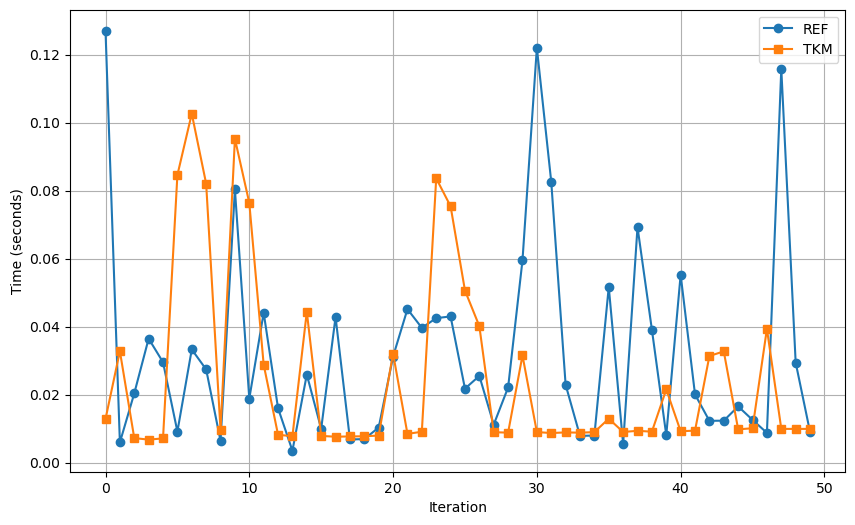

In [39]:
plt.figure(figsize=(10, 6))
plt.plot(time_A, label="REF", linestyle='-', marker='o')
plt.plot(time_B, label="TKM", linestyle='-', marker='s')
plt.xlabel('Iteration')
plt.ylabel('Time (seconds)')
plt.legend(loc='best')
plt.grid(True)
plt.savefig('Diff.png', format='png', dpi=300,bbox_inches='tight')
plt.show()

In [37]:
plt.rcParams.update(plt.rcParamsDefault)

In [64]:
# Generate an initial set of points
points = np.random.rand(num_points, 2)
# print(points)
REF = KMeans(k=3)
model = TKM(k=3)
prev_centre = None
prev = points
n_p = []
p_a = []
p_b = []

for _ in range(51):
    # Generate a new set of points with slight movements based on the previous points
    points = generate_points_with_movement(points, move_probability, max_movement, num_new_points)
    # Record the points changed for Algorithm A
    cnta = 0
    REF.fit(points)
    for i in range(0, len(prev)):
        if abs(points[i][0]-prev[i][0]) > 0:
            cnta = cnta+1
    p_a.append(cnta)
    
    # Record the points changed for Algorithm B
    cntb = 0
    for i in range(0, len(prev)):
        if abs(points[i][1]-prev[i][1]) > max_movement:
            cntb = cntb+1
    p_b.append(cntb)
    model.fit(points,prev_centre)
    prev_centre=model.centers
    prev=np.copy(points)
    n_p.append(len(points))

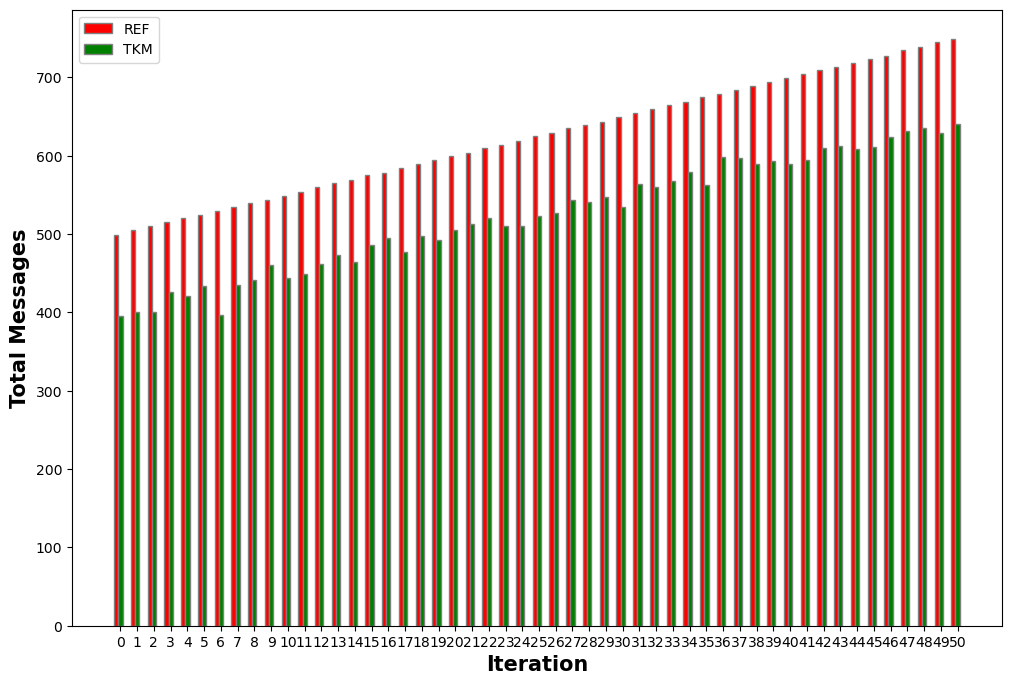

In [82]:
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8)) 
br1 = np.arange(len(p_a)) 
br2 = [x + barWidth for x in br1]  
plt.bar(br1, p_a, color ='r', width = barWidth, edgecolor ='grey', label ='REF') 
plt.bar(br2, p_b, color ='g', width = barWidth, edgecolor ='grey', label ='TKM') 
plt.xlabel('Iteration', fontweight ='bold', fontsize = 15) 
plt.ylabel('Total Messages', fontweight ='bold', fontsize = 15) 
plt.xticks([r + barWidth for r in range(len(p_a))], [i for i in range(0, 51)])
plt.legend()
plt.show() 